In [1]:
# !pip install openai

In [27]:
import pandas as pd
import numpy as np
import re
import json

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report,
    precision_recall_curve, PrecisionRecallDisplay
)

import os
import openai
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [3]:
with open('../secrets.json') as f:
    secrets = json.load(f)

In [4]:
openai.api_key = secrets['chatgpt_api_key']

# Extract one of the folds

In [7]:
with open('../datasets/used_data/03_bert_like_models/02_topics.npy', 'rb') as f:
    topics = np.load(f).tolist()

y_train_u_topics = pd.DataFrame()
y_train_u_topics['topic'] = topics
y_train_u_topics['n'] = 1

In [8]:
cv_fold = []

for i in y_train_u_topics['topic'].unique().reshape(10,-1):
    train_cv = y_train_u_topics.index[ ~np.isin(y_train_u_topics["topic"], i) ].values
    test_cv = y_train_u_topics.index[ np.isin(y_train_u_topics["topic"], i) ].values
    
    cv_fold.append( [train_cv, test_cv])

In [9]:
df_basic_info = pd.read_parquet('../datasets/used_data/03_bert_like_models/01_basic_info_data.parquet')

In [10]:
df_basic_info.head()

,assestment,text,text_clean
0,0,(...) udzielenie bankowi centralnemu Ukrainy t...,udzielenie bankowi centralnemu Ukrainy tzw. s...
1,0,Polska już w grudniu (2021 roku – przyp. Dema...,Polska już w grudniu 2021 roku miała trzecią n...
2,0,(Bartosz Cichocki – przyp. Demagog) był jedyny...,Bartosz Cichocki był jedynym ambasadorem z kra...
3,1,Będąc (prezes NBP Adam Glapiński – przyp. D...,Będąc prezes NBP Adam Glapiński przez 6 lat os...
4,0,W latach 2018–2019 Narodowy Bank Polski zakupi...,W latach 2018–2019 Narodowy Bank Polski zakupi...


# Get results from ChatGPT

In [9]:
promopt = 'Zaklasyfikuj poniższe zdanie jako prawdziwe (True) lub fałszywe (Fake), odpowiedz uzywajac jednego słowa - True/Fake:'

In [10]:
# y_zero_shot_test = []

# # train_i_chat, test_i_chat = cv_fold[0]

# for t in tqdm(df_basic_info['text'].values, total=df_basic_info.shape[0]):
#     messages = [ {"role": "system", "content": promopt} ]

#     messages.append( 
#         {"role": "user", "content": t}, 
#     ) 
#     chat = openai.ChatCompletion.create( 
#         model="gpt-3.5-turbo", messages=messages 
#     ) 
      
#     reply = chat.choices[0].message.content 
    
#     y_zero_shot_test.append(reply)

In [11]:
# y_zero_shot_test

In [72]:
np.unique(np.array(y_zero_shot_test))

array(['Fake', 'Fake.', 'False', 'False.', 'Fałsz', 'Fałsz.', 'Fałszywe',
       'Nie mogę oceniać prawdziwości tego zdania, ponieważ brakuje konkretnych informacji o poziomie zgonów oraz państwach, o których mowa.',
       'Nie mogę ocenić poglądów osoby, która nie została określona.',
       'Nie mogę ocenić prawdziwości tego zdania na podstawie podanych informacji.',
       'Nie mogę udzielić odpowiedzi na to pytanie na podstawie dostępnych informacji.',
       'Nie posiadam wystarczających informacji, aby potwierdzić lub zaprzeczyć prawdziwość tego zdania.',
       'Nie znam stanowiska PSL w sprawie przyjmowania uchodźców ani intencji Adama Jarubasa w tej kwestii.',
       'Prawdziwe', 'True', 'True.'], dtype='<U132')

In [77]:
y_zero_shot_test_int = []

for r in y_zero_shot_test:
    y_zero_shot_test_int.append( ('True' not in r) | ('Prawdziwe' not in r) )

In [89]:
df_zero_out = pd.DataFrame(
    {
        'chatgpt_output' : y_zero_shot_test,
        'label' : y_zero_shot_test_int,
    },
    index = df_basic_info.index
)

df_zero_out['label'] = df_zero_out['label'].astype(int)
df_zero_out.loc[df_zero_out['chatgpt_output'].str.contains('Nie'), 'label'] = -1

df_zero_out.to_parquet('../datasets/used_data/04_decoder_model/01_zero_shot_chatgpt_labels.parquet')

In [90]:
len(y_zero_shot_test_int)

6529

In [91]:
df_basic_info.shape

(6529, 3)

In [101]:
df_zero_out[df_zero_out['label'] == -1]['chatgpt_output'].values

array(['Nie mogę udzielić odpowiedzi na to pytanie na podstawie dostępnych informacji.',
       'Nie mogę ocenić prawdziwości tego zdania na podstawie podanych informacji.',
       'Nie znam stanowiska PSL w sprawie przyjmowania uchodźców ani intencji Adama Jarubasa w tej kwestii.',
       'Nie mogę ocenić poglądów osoby, która nie została określona.',
       'Nie posiadam wystarczających informacji, aby potwierdzić lub zaprzeczyć prawdziwość tego zdania.',
       'Nie mogę oceniać prawdziwości tego zdania, ponieważ brakuje konkretnych informacji o poziomie zgonów oraz państwach, o których mowa.'],
      dtype=object)

In [100]:
df_basic_info[df_zero_out['label'] == -1]['text'].values

array(['Ja się pytam, które słowa prezesa Kaczyńskiego są prawdziwe? Bo kilka lat temu powiedział, że z Le Pen macie państwo tyle wspólnego, PiS ma tyle wspólnego, rozumiem, co z Putinem.',
       'Jakie były przesłanki aby ją (kopalnie Ruch Śląsk) oddać  do SRK, ponieważ ta kopalnia ma najlepszy jakościowo węgiel koksujący.',
       'Czy PSL jest za przyjmowaniem uchodźców i czy jeżeli Adam Jarubas zostanie marszałkiem po wyborach, to zgodzi się na to, aby imigranci przyjechali do regionu świętokrzyskiego?',
       'Ma dobre poglądy [o Ursuli von der Leyen - red.].',
       'Tak postąpiono z bł. Jerzym Popiełuszką, którego najpierw usiłowano zniesławić przy pomocy kłamstw i prowokacji, a gdy to się nie powiodło, związano go i wrzucono do Wisły. Coś podobnego dzieje się teraz z arcybiskupem Jędraszewskim',
       'Zobaczcie, jaki jest poziom zgonów na jeden milion mieszkańców w państwach daleko bogatszych od nas. I co na to powiecie?\xa0'],
      dtype=object)

In [92]:
y_test = df_basic_info[df_zero_out['label'] > -1]['assestment'].values

In [93]:
y_pred = np.array(y_zero_shot_test_int)[df_zero_out['label'] > -1]

In [94]:
accuracy_score(y_test, y_pred) 

0.5256783688486892

In [95]:
f1_score(y_test, y_pred) 

0.6891077170418006

In [39]:
y_test = df_basic_info['assestment'].values

In [40]:
df_zero_out = pd.read_parquet('../datasets/used_data/04_decoder_model/01_zero_shot_chatgpt_labels.parquet')

In [41]:
df_zero_out['chatgpt_output'].value_counts()

chatgpt_output
True                                                                                                                                    3622
Fake                                                                                                                                    2033
False                                                                                                                                    831
Fake.                                                                                                                                     14
Fałszywe                                                                                                                                   9
True.                                                                                                                                      5
Fałsz                                                                                                                                      

In [42]:
df_zero_out['chatgpt_output'].unique()

array(['True', 'Fake', 'False', 'Fake.',
       'Nie mogę udzielić odpowiedzi na to pytanie na podstawie dostępnych informacji.',
       'Fałsz.', 'Fałszywe', 'True.',
       'Nie mogę ocenić prawdziwości tego zdania na podstawie podanych informacji.',
       'Prawdziwe', 'False.', 'Fałsz',
       'Nie znam stanowiska PSL w sprawie przyjmowania uchodźców ani intencji Adama Jarubasa w tej kwestii.',
       'Nie mogę ocenić poglądów osoby, która nie została określona.',
       'Nie posiadam wystarczających informacji, aby potwierdzić lub zaprzeczyć prawdziwość tego zdania.',
       'Nie mogę oceniać prawdziwości tego zdania, ponieważ brakuje konkretnych informacji o poziomie zgonów oraz państwach, o których mowa.'],
      dtype=object)

In [43]:
df_zero_out.loc[df_zero_out['chatgpt_output'].isin(['True', 'True.', 'Prawdziwe']), 'label'] = 0

In [50]:
df_zero_out['label'].value_counts()

label
 0    3628
 1    2895
-1       6
Name: count, dtype: int64

In [44]:
y_pred = df_zero_out['label'].values

In [45]:
y_test = y_test[y_pred>-1]
y_pred = y_pred[y_pred>-1]

In [46]:
accuracy_score(y_test, y_pred) 

0.5676835811743063

In [47]:
f1_score(y_test, y_pred) 

0.5540796963946869

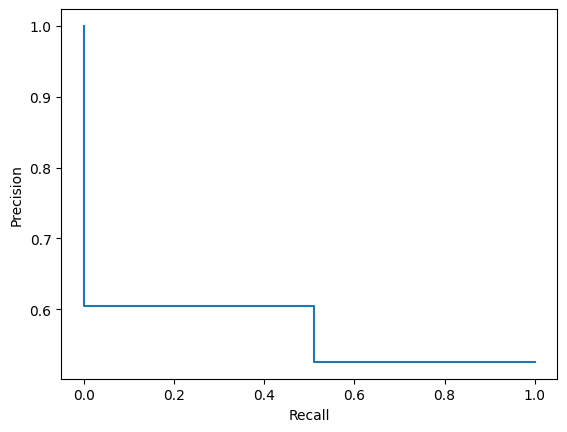

In [49]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()